## Первое задание: "Реализация MAXQ-0 алгоритма для среды Taxi"
### Чернявского Александра

## Среда Taxi (обзор)
### источник: https://www.oreilly.com/learning/introduction-to-reinforcement-learning-and-openai-gym

In [1]:
%load_ext pycodestyle_magic

In [2]:
import gym
env = gym.make("Taxi-v2")
observation = env.reset()
for _ in range(10):
    env.render()  # визуализация
    action = env.action_space.sample()
    print(action)
    observation, reward, done, info = env.step(action)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

4
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
5
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
0
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
3
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
3
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
3
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
1
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
3
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
5
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
2


In [3]:
env.observation_space.n # количество состояний всего

500

Возможны 6 действий: down (0), up (1), right (2), left (3), pick-up (4), and drop-off (5)

Награда: -1 за шаг, -10 за неправильную посадку/высадку, все ок: +20

In [4]:
env.env.s = 114
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)


In [5]:
env.step(1)

(14, -1, False, {'prob': 1.0})

In [6]:
env.render() # для отображения

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)


In [7]:
env.step(1)

(14, -1, False, {'prob': 1.0})

In [8]:
state = env.reset()
counter = 0
reward = None
while reward != 20:
    state, reward, done, info = env.step(env.action_space.sample())
    counter += 1

print(counter)

3758


In [9]:
import numpy as np
import random

alpha = 0.65  # lr
num_episodes = 2500

q_actions = np.zeros_like(range(1, num_episodes + 1, 100)) * 1.0
q_reward = np.zeros_like(range(1, num_episodes + 1, 100)) * 1.0

for k in range(10):  # запустим несколько раз и усредним, чтобы уменьшить разброс в результатах
    eps = 0.15  # параметр для E-greedy
    sum_count = 0.
    sum_reward = 0.
    q_cur_actions = []
    q_cur_reward = []
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    for episode in range(1, num_episodes + 1):
        eps *= 0.99  # eps будем уменьшать, т.к. в конце темп исследования среды уже не так важен
        done = False
        state = env.reset()
        while not done:
            action = np.argmax(Q[state])  # выбираем действие с наиболее высоким Q-val для данного состояния
            if random.random() < eps:
                action = random.randint(0, 5)
            state2, reward, done, info = env.step(action)
            Q[state, action] += alpha * (reward + np.max(Q[state2]) - Q[state, action])
            sum_count += 1
            sum_reward += reward
            state = state2
        if episode % 100 == 0:
            sum_count /= 100.
            sum_reward /= 100.
            if k == 0:
                print('After episodes {} Total actions: {}'.format(episode, sum_count))
            q_cur_actions.append(sum_count)
            q_cur_reward.append(sum_reward)
            sum_count = 0.
            sum_reward = 0.
    q_actions += np.array(q_cur_actions)
    q_reward += np.array(q_cur_reward)
q_actions /= 10
q_reward /= 10

After episodes 100 Total actions: 133.54
After episodes 200 Total actions: 46.88
After episodes 300 Total actions: 20.29
After episodes 400 Total actions: 15.87
After episodes 500 Total actions: 14.48
After episodes 600 Total actions: 12.89
After episodes 700 Total actions: 13.12
After episodes 800 Total actions: 13.05
After episodes 900 Total actions: 12.79
After episodes 1000 Total actions: 12.89
After episodes 1100 Total actions: 12.58
After episodes 1200 Total actions: 13.17
After episodes 1300 Total actions: 12.71
After episodes 1400 Total actions: 13.0
After episodes 1500 Total actions: 12.61
After episodes 1600 Total actions: 12.78
After episodes 1700 Total actions: 12.91
After episodes 1800 Total actions: 13.05
After episodes 1900 Total actions: 12.61
After episodes 2000 Total actions: 12.94
After episodes 2100 Total actions: 12.76
After episodes 2200 Total actions: 12.4
After episodes 2300 Total actions: 12.79
After episodes 2400 Total actions: 12.61
After episodes 2500 Total 

## Реализация алгоритма MAXQ-0 для данной среды

### статья: https://jair.org/index.php/jair/article/view/10266

In [10]:
import random


def decode(s):
    '''
    input:
    state s
    
    output:
    array [taxirow, taxicol, passidx, destidx], where
    passidx and destidx are indexes in locations - R, G, B, Y, taxi
    '''
    
    out = []
    out.append(s % 4)
    s = s // 4
    out.append(s % 5)
    s = s // 5
    out.append(s % 5)
    s = s // 5
    out.append(s)
    assert 0 <= s < 5
    
    return reversed(out)


def action(i):
    return {"South": 0, "North": 1, "East": 2, "West": 3, "Pickup": 4, "Putdown": 5}[i]


def task(i):
    return {"Root": 0, "Get": 1, "Put": 2, "Navigate_S": 3, "Navigate_D": 4,
            "North": 5, "East": 6, "West": 7, "South": 8, "Pickup": 9, "Putdown": 10}[i]


def subtasks(i):
    # tree of substacks
    return {"Root": ["Get", "Put"],
           "Get": ["Pickup", "Navigate_S"],
           "Put": ["Putdown", "Navigate_D"],
           "Navigate_S": ["North", "East", "West", "South"],
           "Navigate_D": ["North", "East", "West", "South"]}[i]


def is_terminal(i, s, done):
    '''
    input:
    maxnode i
    state s
    done
    
    output:
    does this state terminal for task i?
    '''
    
    taxirow, taxicol, passidx, destidx = decode(s)
    
    if i == "Root" and done:
        return True
    
    if i == "Get" and passidx >= 4 or i == "Put" and (passidx < 4 or done):
        return True
    
    locs = [[0, 0], [0, 4], [4, 0], [4, 3], [taxirow, taxicol]]
    if i == "Navigate_S" and [taxirow, taxicol] == locs[passidx] or\
        i == "Navigate_D" and [taxirow, taxicol] == locs[destidx]:
            return True
    
    return False


def is_action(i):
    return (i in ["North", "East", "West", "South", "Pickup", "Putdown"])


def find_V(i, s, V, C):
    # compute value function (recurrent as DFS)
    if is_action(i):
        return V[action(i), s]
    else:
        max_Q = -1000000
        for a in subtasks(i):
            Q = find_V(a, s, V, C) + C[task(i), s, task(a)]
            if Q > max_Q:
                max_Q = Q
        return max_Q
    
    
def find_a_maxQ(i, s, V, C, eps):
    # pi-strategy -- E-greedy algorithm
    max_Q = -1000000
    subtask = subtasks(i)
    a_res = subtask[0]
    for a in subtask:
        Q = find_V(a, s, V, C) + C[task(i), s, task(a)]
        if Q > max_Q:
            max_Q = Q
            a_res = a
    if random.random() < eps:
        a_res = subtask[random.randint(0, len(subtask)-1)]
    return a_res

In [11]:
def MAXQ_0(i, s, V, C, alpha=0.7, gamma=0.99, eps=0.1, done=False):
    '''
    input:
    maxNode i
    state s
    current value function V
    current completion function C
    alpha - learning rate
    gamma - discount parameter
    eps - probability for E-Greedy
    
    output:
    count - number of steps
    reward
    state - result state
    result functions V, C
    done
    '''
    
    if is_action(i):
        s, r, done, _ = env.step(action(i))
        V[action(i), s] += alpha * (r - V[action(i), s])
        return 1, r, s, V, C, done
    else:
        count = 0
        reward = 0
        while not is_terminal(i, s, done) and count < 1000:
            a = find_a_maxQ(i, s, V, C, eps)
            N, r, state, V, C, done = MAXQ_0(a, s, V, C, alpha=alpha*0.99)
            V_new = find_V(i, state, V, C)
            C[task(i), s, task(a)] += alpha * (V_new * gamma**N - C[task(i), s, task(a)])
            count += N
            reward += r
            s = state
        return count, reward, s, V, C, done

In [12]:
import gym
import numpy as np

env = gym.make("Taxi-v2")

num_v = 6
num_tasks = 11

In [13]:
alpha = 0.65  # lr
gamma = 0.99  # discount
num_episodes = 2500

q0_actions = np.zeros_like(range(1, num_episodes + 1, 100)) * 1.0
q0_reward = np.zeros_like(range(1, num_episodes + 1, 100)) * 1.0

for k in range(10):
    V = -0.5 * np.ones(shape=(num_v, env.observation_space.n)) 
    C = -0.5 * np.ones(shape=(num_tasks, env.observation_space.n, num_tasks))
    # Значения для инициализации подобраны исходя из скорости сходимости
    
    eps = 0.15  # параметр для E-greedy
    sum_count = 0.
    sum_reward = 0.
    q0_cur_actions = []
    q0_cur_reward = []
    for i in range(1, num_episodes + 1):
        eps *= 0.99
        start_state = env.reset()
        count, reward, _, V, C, _ = MAXQ_0("Root", start_state, V, C, done=False, eps=eps, alpha=alpha, gamma=gamma)
        sum_count += count
        sum_reward += reward
        if i % 100 == 0:
            sum_count /= 100.
            sum_reward /= 100.
            if k == 0:
                print('After {} episodes Total actions: {}'.format(i,sum_count))
            q0_cur_actions.append(sum_count)
            q0_cur_reward.append(sum_reward)
            sum_count = 0.
            sum_reward = 0.
    q0_actions += np.array(q0_cur_actions)
    q0_reward += np.array(q0_cur_reward)
q0_actions /= 10.
q0_reward /= 10.

After 100 episodes Total actions: 92.25
After 200 episodes Total actions: 30.76
After 300 episodes Total actions: 20.44
After 400 episodes Total actions: 18.31
After 500 episodes Total actions: 16.49
After 600 episodes Total actions: 15.64
After 700 episodes Total actions: 15.71
After 800 episodes Total actions: 15.81
After 900 episodes Total actions: 14.1
After 1000 episodes Total actions: 13.63
After 1100 episodes Total actions: 14.41
After 1200 episodes Total actions: 14.01
After 1300 episodes Total actions: 14.66
After 1400 episodes Total actions: 13.8
After 1500 episodes Total actions: 14.95
After 1600 episodes Total actions: 14.33
After 1700 episodes Total actions: 14.04
After 1800 episodes Total actions: 14.89
After 1900 episodes Total actions: 13.21
After 2000 episodes Total actions: 14.54
After 2100 episodes Total actions: 14.03
After 2200 episodes Total actions: 13.81
After 2300 episodes Total actions: 14.32
After 2400 episodes Total actions: 13.72
After 2500 episodes Total a

## Сравнение алгоритмов Q-learning и MAXQ-0

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline

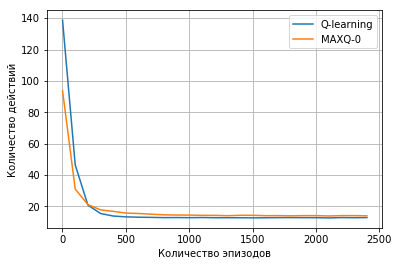

In [15]:
plt.plot(range(1, 2501, 100), q_actions, label='Q-learning')
plt.plot(range(1, 2501, 100), q0_actions, label='MAXQ-0')
plt.legend()
plt.grid()
plt.xlabel("Количество эпизодов")
plt.ylabel("Количество действий")

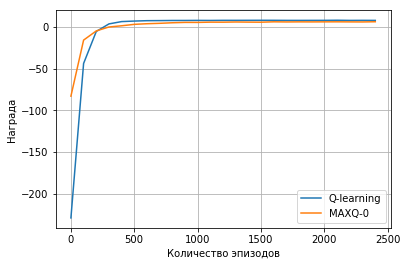

In [16]:
plt.plot(range(1, 2501, 100), q_reward, label='Q-learning')
plt.plot(range(1, 2501, 100), q0_reward, label='MAXQ-0')
plt.legend()
plt.grid()
plt.xlabel("Количество эпизодов")
plt.ylabel("Награда")

Из графиков видно, что после большого количества эпизодов MAXQ-0 алгоритм работает даже чуть хуже, чем Q-learning, хотя по началу между ними видна значительная разница. Это может быть связано с не совсем правильным выбором параметров, либо с не самой удачной инициализацией.